# Coach Slide-Ready Workbook

This notebook is a consumer of Notebook 01 outputs.
It reads `outputs/results.json` and exported tables/figures without recomputing analysis.

## 0. Setup
- Run Notebook 01 first (or `scripts/render_visual_templates.py`).
- This notebook only formats text/tables and aliases figures for deck insertion.

In [13]:
import shutil

from pathlib import Path
import pandas as pd
from IPython.display import Image, Markdown, display

from browns_tracking.config import default_project_paths
from browns_tracking.pipeline import classify_hsr_exposure
from browns_tracking.presentation import (
    build_slide_1_snapshot_text,
    coach_early_late_table,
    coach_extrema_table,
    coach_peak_distance_table,
    coach_segment_table,
    coach_speed_band_table,
    write_slide_text,
)
from browns_tracking.results_contract import load_results_contract

pd.set_option('display.max_columns', 140)
pd.set_option('display.width', 240)

In [14]:
paths = default_project_paths()
OUTPUT_DIR = paths.output_dir
FIG_DIR = OUTPUT_DIR / 'figures'
TABLE_DIR = OUTPUT_DIR / 'tables'
TEXT_DIR = OUTPUT_DIR / 'slide_text'
TABLE_DIR.mkdir(parents=True, exist_ok=True)
TEXT_DIR.mkdir(parents=True, exist_ok=True)

contract = load_results_contract(OUTPUT_DIR)
session_summary = contract['session_summary']
qa_summary = contract['qa_summary']
qc_status = contract.get('qc_status', 'QC FAILED')
overall_status = str(qa_summary.get('overall_status', 'UNKNOWN')).upper()
if overall_status == 'UNKNOWN':
    if qc_status == 'QC PASS':
        overall_status = 'PASS'
    elif qc_status == 'QC WARN':
        overall_status = 'WARN'
    else:
        overall_status = 'FAIL'
validation_takeaways = contract.get('validation_takeaways', [])
thresholds = contract['thresholds']
hsr_threshold_mph = float(thresholds['hsr_threshold_mph'])
sprint_threshold_mph = float(
    thresholds.get(
        'sprint_threshold_mph',
        next(
            (
                float(band.get('lower_mph', 16.0))
                for band in thresholds.get('speed_bands_mph', [])
                if str(band.get('name', '')).strip().lower() == 'sprint'
            ),
            16.0,
        ),
    )
)
accel_threshold_ms2 = float(thresholds['accel_threshold_ms2'])
decel_threshold_ms2 = float(thresholds['decel_threshold_ms2'])
speed_bands = thresholds['speed_bands_mph']
units = contract.get('units', {})
speed_conversion_factor = float(units.get('speed_conversion', {}).get('factor', 2.0454545))
accel_conversion_factor = float(units.get('acceleration_conversion', {}).get('factor', 0.9144))

speed_band_summary = pd.read_csv(TABLE_DIR / 'absolute_speed_band_summary.csv')
distance_table = pd.read_csv(TABLE_DIR / 'peak_distance_windows.csv')
extrema = pd.read_csv(TABLE_DIR / 'session_extrema.csv')
event_counts = pd.read_csv(TABLE_DIR / 'session_event_counts.csv').iloc[0].to_dict()
early_late_summary = pd.read_csv(TABLE_DIR / 'early_vs_late_summary.csv')
coach_phase_summary = pd.read_csv(TABLE_DIR / 'coach_phase_summary.csv')
session_structure_map = pd.read_csv(TABLE_DIR / 'session_structure_map.csv')
validation_gates = pd.read_csv(TABLE_DIR / 'validation_gates.csv')
top_windows_by_duration = pd.read_csv(TABLE_DIR / 'top_windows_by_duration.csv')

required_figures = [
    FIG_DIR / '01_space.png',
    FIG_DIR / '02_time.png',
    FIG_DIR / '03_peaks.png',
]
missing_figures = [str(p) for p in required_figures if not p.exists()]
if missing_figures:
    raise FileNotFoundError(
        'Missing canonical figures. Run Notebook 01 or scripts/render_visual_templates.py first:\n'
        + '\n'.join(missing_figures)
    )

pd.Series({
    'Contract': str(OUTPUT_DIR / 'results.json'),
    'Model': contract['model']['name'],
    'Questions': '; '.join(contract['story_questions']),
}, name='value').to_frame()

,value
Contract,C:\docker_projects\browns_performance_science_...
Model,Balanced Football Session Model v1
Questions,Where did the player spend time (role/space)?;...


In [15]:
def show_saved_png(path, caption='', width=1250):
    png = Path(path)
    if caption:
        display(Markdown(f'**{caption}**'))
    if not png.exists():
        display(Markdown(f':warning: Missing `{png}`.'))
        return
    display(Image(filename=str(png), width=width))

## Deck Map (Use This 6-Slide Flow)

In [16]:
if overall_status == 'PASS':
    slide1_takeaway = 'Data quality gates passed at a usable level, so workload outputs are decision-ready.'
elif overall_status == 'WARN':
    slide1_takeaway = 'Data quality is usable with caveats; continuity masking and block-limited windows were applied.'
else:
    slide1_takeaway = 'Data quality failed trust gates; use this session only for descriptive review, not workload decisions.'

deck_outline = pd.DataFrame([
    {
        'slide': 1,
        'title': 'Session Snapshot + Validation Gates',
        'figure_or_table': (
            'outputs/tables/slide_1_data_quality_table.csv; '
            'outputs/tables/slide_1_validation_gates_table.csv; '
            'outputs/tables/slide_1_qc_checks_table.csv'
        ),
        'one_line_takeaway': slide1_takeaway,
    },
    {
        'slide': 2,
        'title': 'Where: Spatial Usage and Role Signature',
        'figure_or_table': (
            'outputs/figures/01_space.png; outputs/phase_table.csv; '
            'outputs/session_structure_map.csv'
        ),
        'one_line_takeaway': 'The session lived in specific field zones and repeated role-consistent movement patterns.'
    },
    {
        'slide': 3,
        'title': 'When: Intensity Timeline and Session Structure',
        'figure_or_table': 'outputs/figures/02_time.png; outputs/tables/slide_3_top_windows_table.csv',
        'one_line_takeaway': 'High-intensity work clustered in identifiable blocks rather than being evenly distributed.'
    },
    {
        'slide': 4,
        'title': 'What: Peak Demands and Repeatable Windows',
        'figure_or_table': (
            'outputs/figures/03_peaks.png; outputs/tables/slide_3_peak_distance_table.csv; '
            'outputs/tables/slide_3_event_counts_table.csv'
        ),
        'one_line_takeaway': 'Top windows define the true worst-case demands to anchor drill and conditioning targets.'
    },
    {
        'slide': 5,
        'title': 'Phase-Level Load Profile',
        'figure_or_table': 'outputs/tables/slide_4_segment_table.csv',
        'one_line_takeaway': 'Merged coach phases show which blocks carried most distance and high-speed stress.'
    },
    {
        'slide': 6,
        'title': 'Early vs Late Readiness Signal',
        'figure_or_table': 'outputs/tables/slide_5_early_late_table.csv',
        'one_line_takeaway': 'Late-session drift quantifies whether second-half output matched training intent.'
    },
])
display(deck_outline)
deck_outline.to_csv(TABLE_DIR / 'final_deck_outline.csv', index=False)

,slide,title,figure_or_table,one_line_takeaway
0,1,Session Snapshot + Validation Gates,outputs/tables/slide_1_data_quality_table.csv;...,Data quality is usable with caveats; continuit...
1,2,Where: Spatial Usage and Role Signature,outputs/figures/01_space.png; outputs/phase_ta...,The session lived in specific field zones and ...
2,3,When: Intensity Timeline and Session Structure,outputs/figures/02_time.png; outputs/tables/sl...,High-intensity work clustered in identifiable ...
3,4,What: Peak Demands and Repeatable Windows,outputs/figures/03_peaks.png; outputs/tables/s...,Top windows define the true worst-case demands...
4,5,Phase-Level Load Profile,outputs/tables/slide_4_segment_table.csv,Merged coach phases show which blocks carried ...
5,6,Early vs Late Readiness Signal,outputs/tables/slide_5_early_late_table.csv,Late-session drift quantifies whether second-h...


## Coach/Player Visual Report (Auto-Display)

**Slide 2 | Where: Spatial usage and role signature (density + key demand windows)**

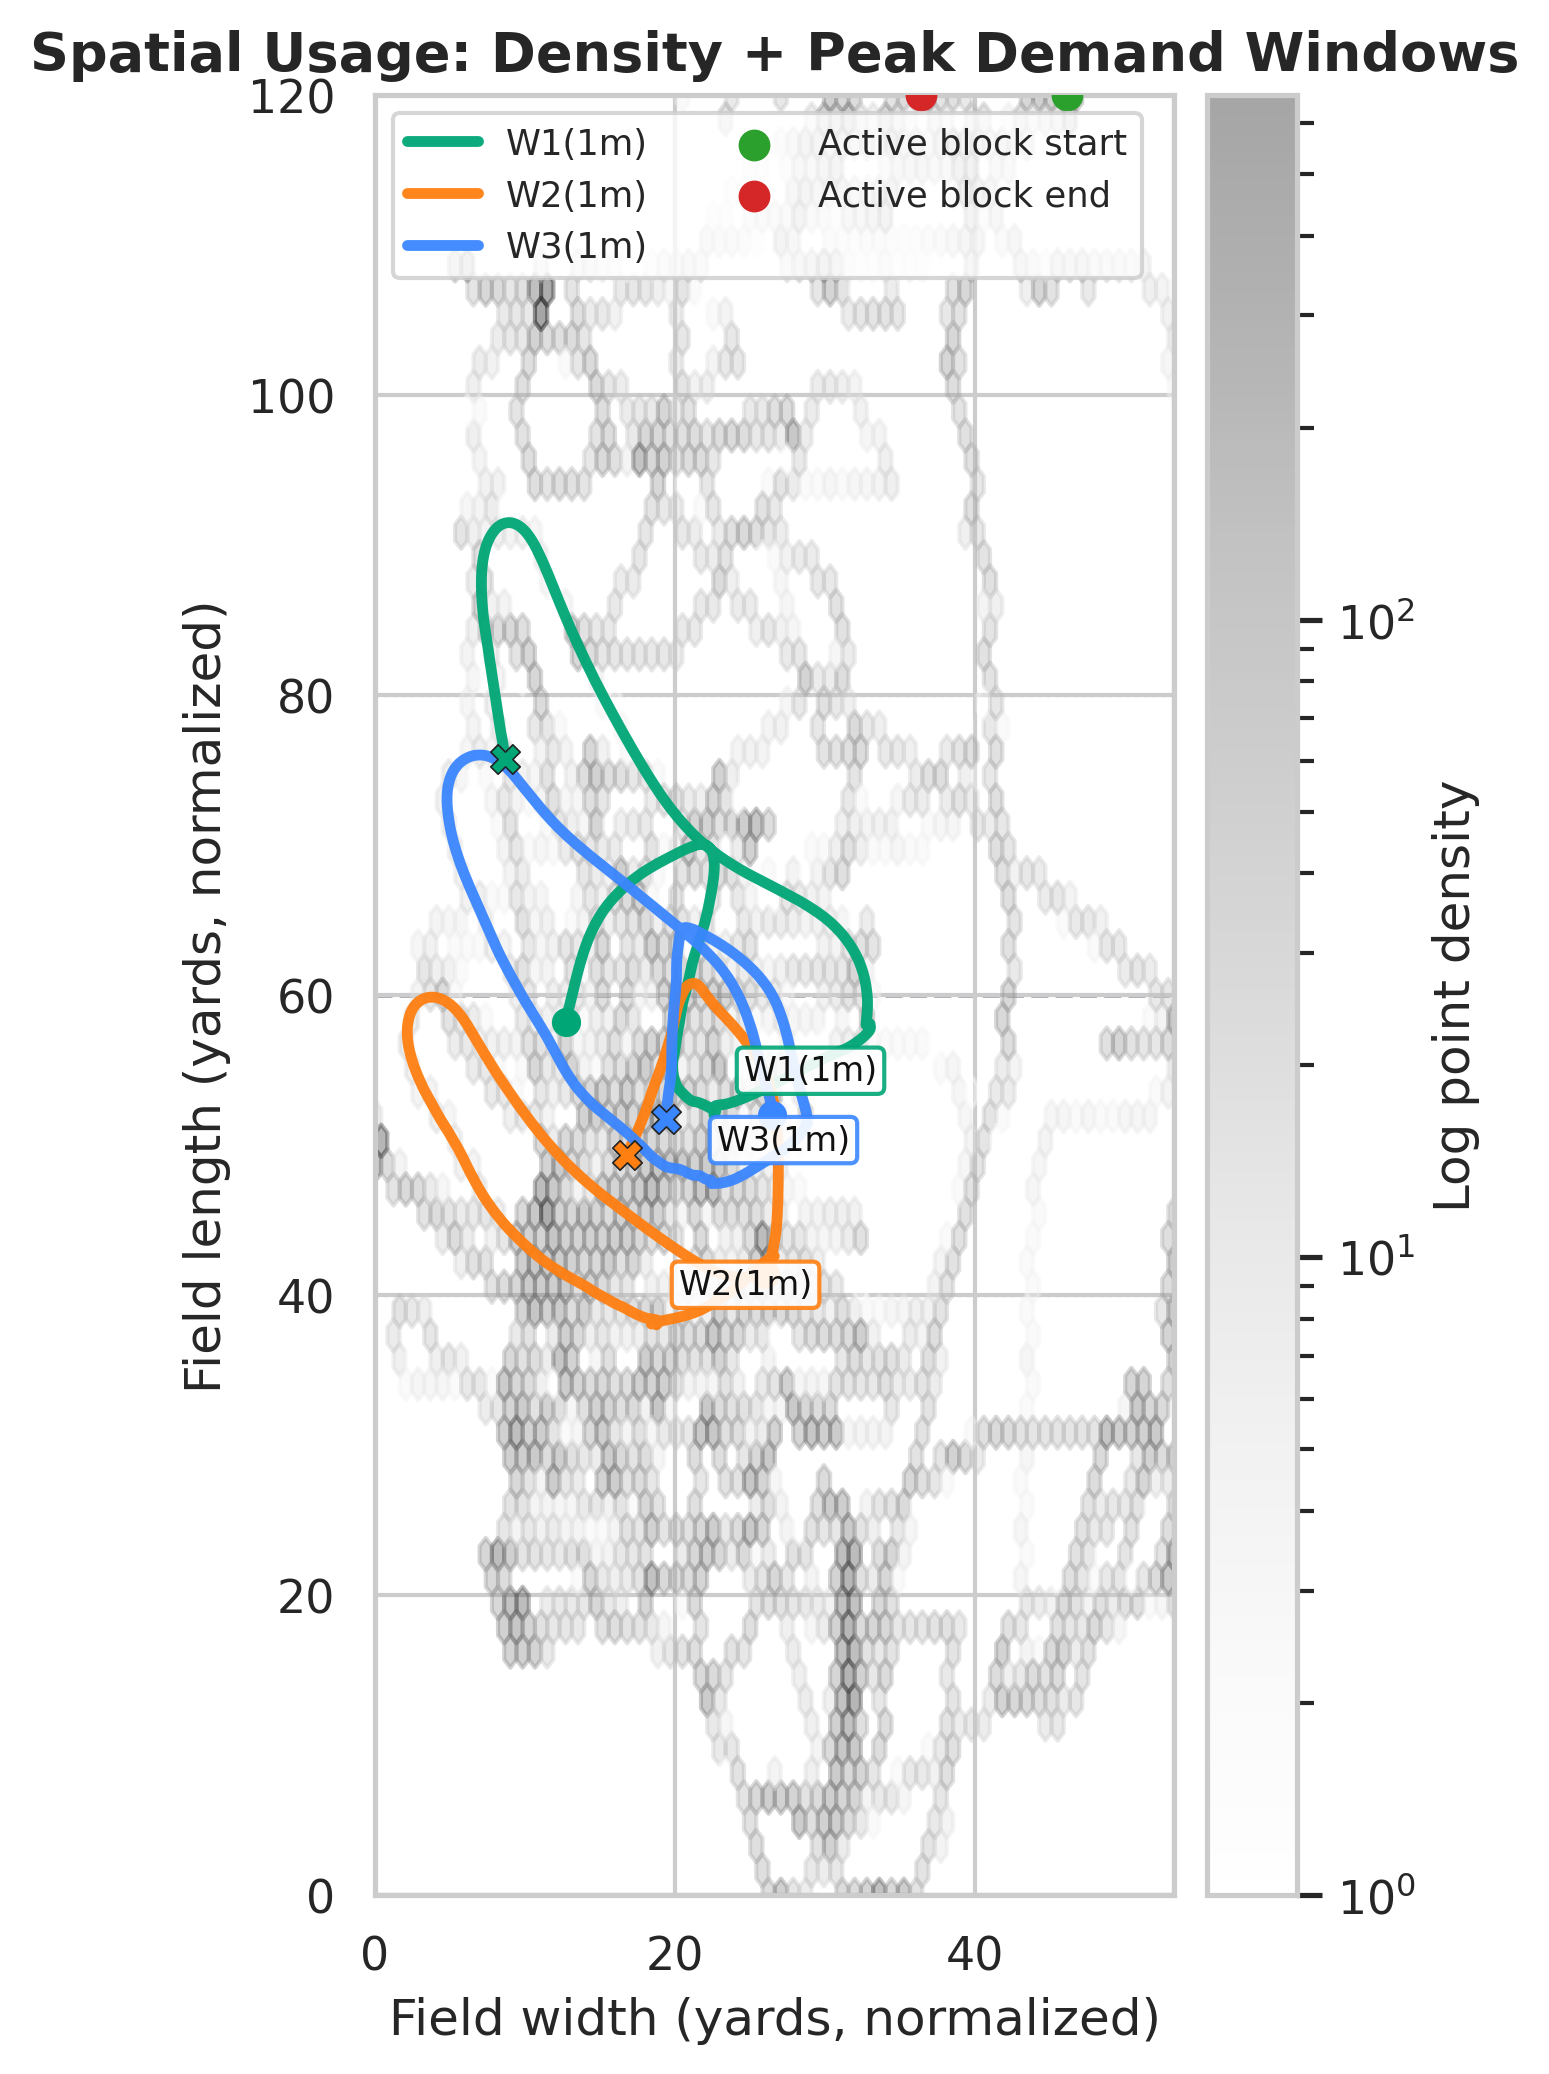

**Slide 3 | When: Intensity over time with phase strip, HSR events, and peak windows**

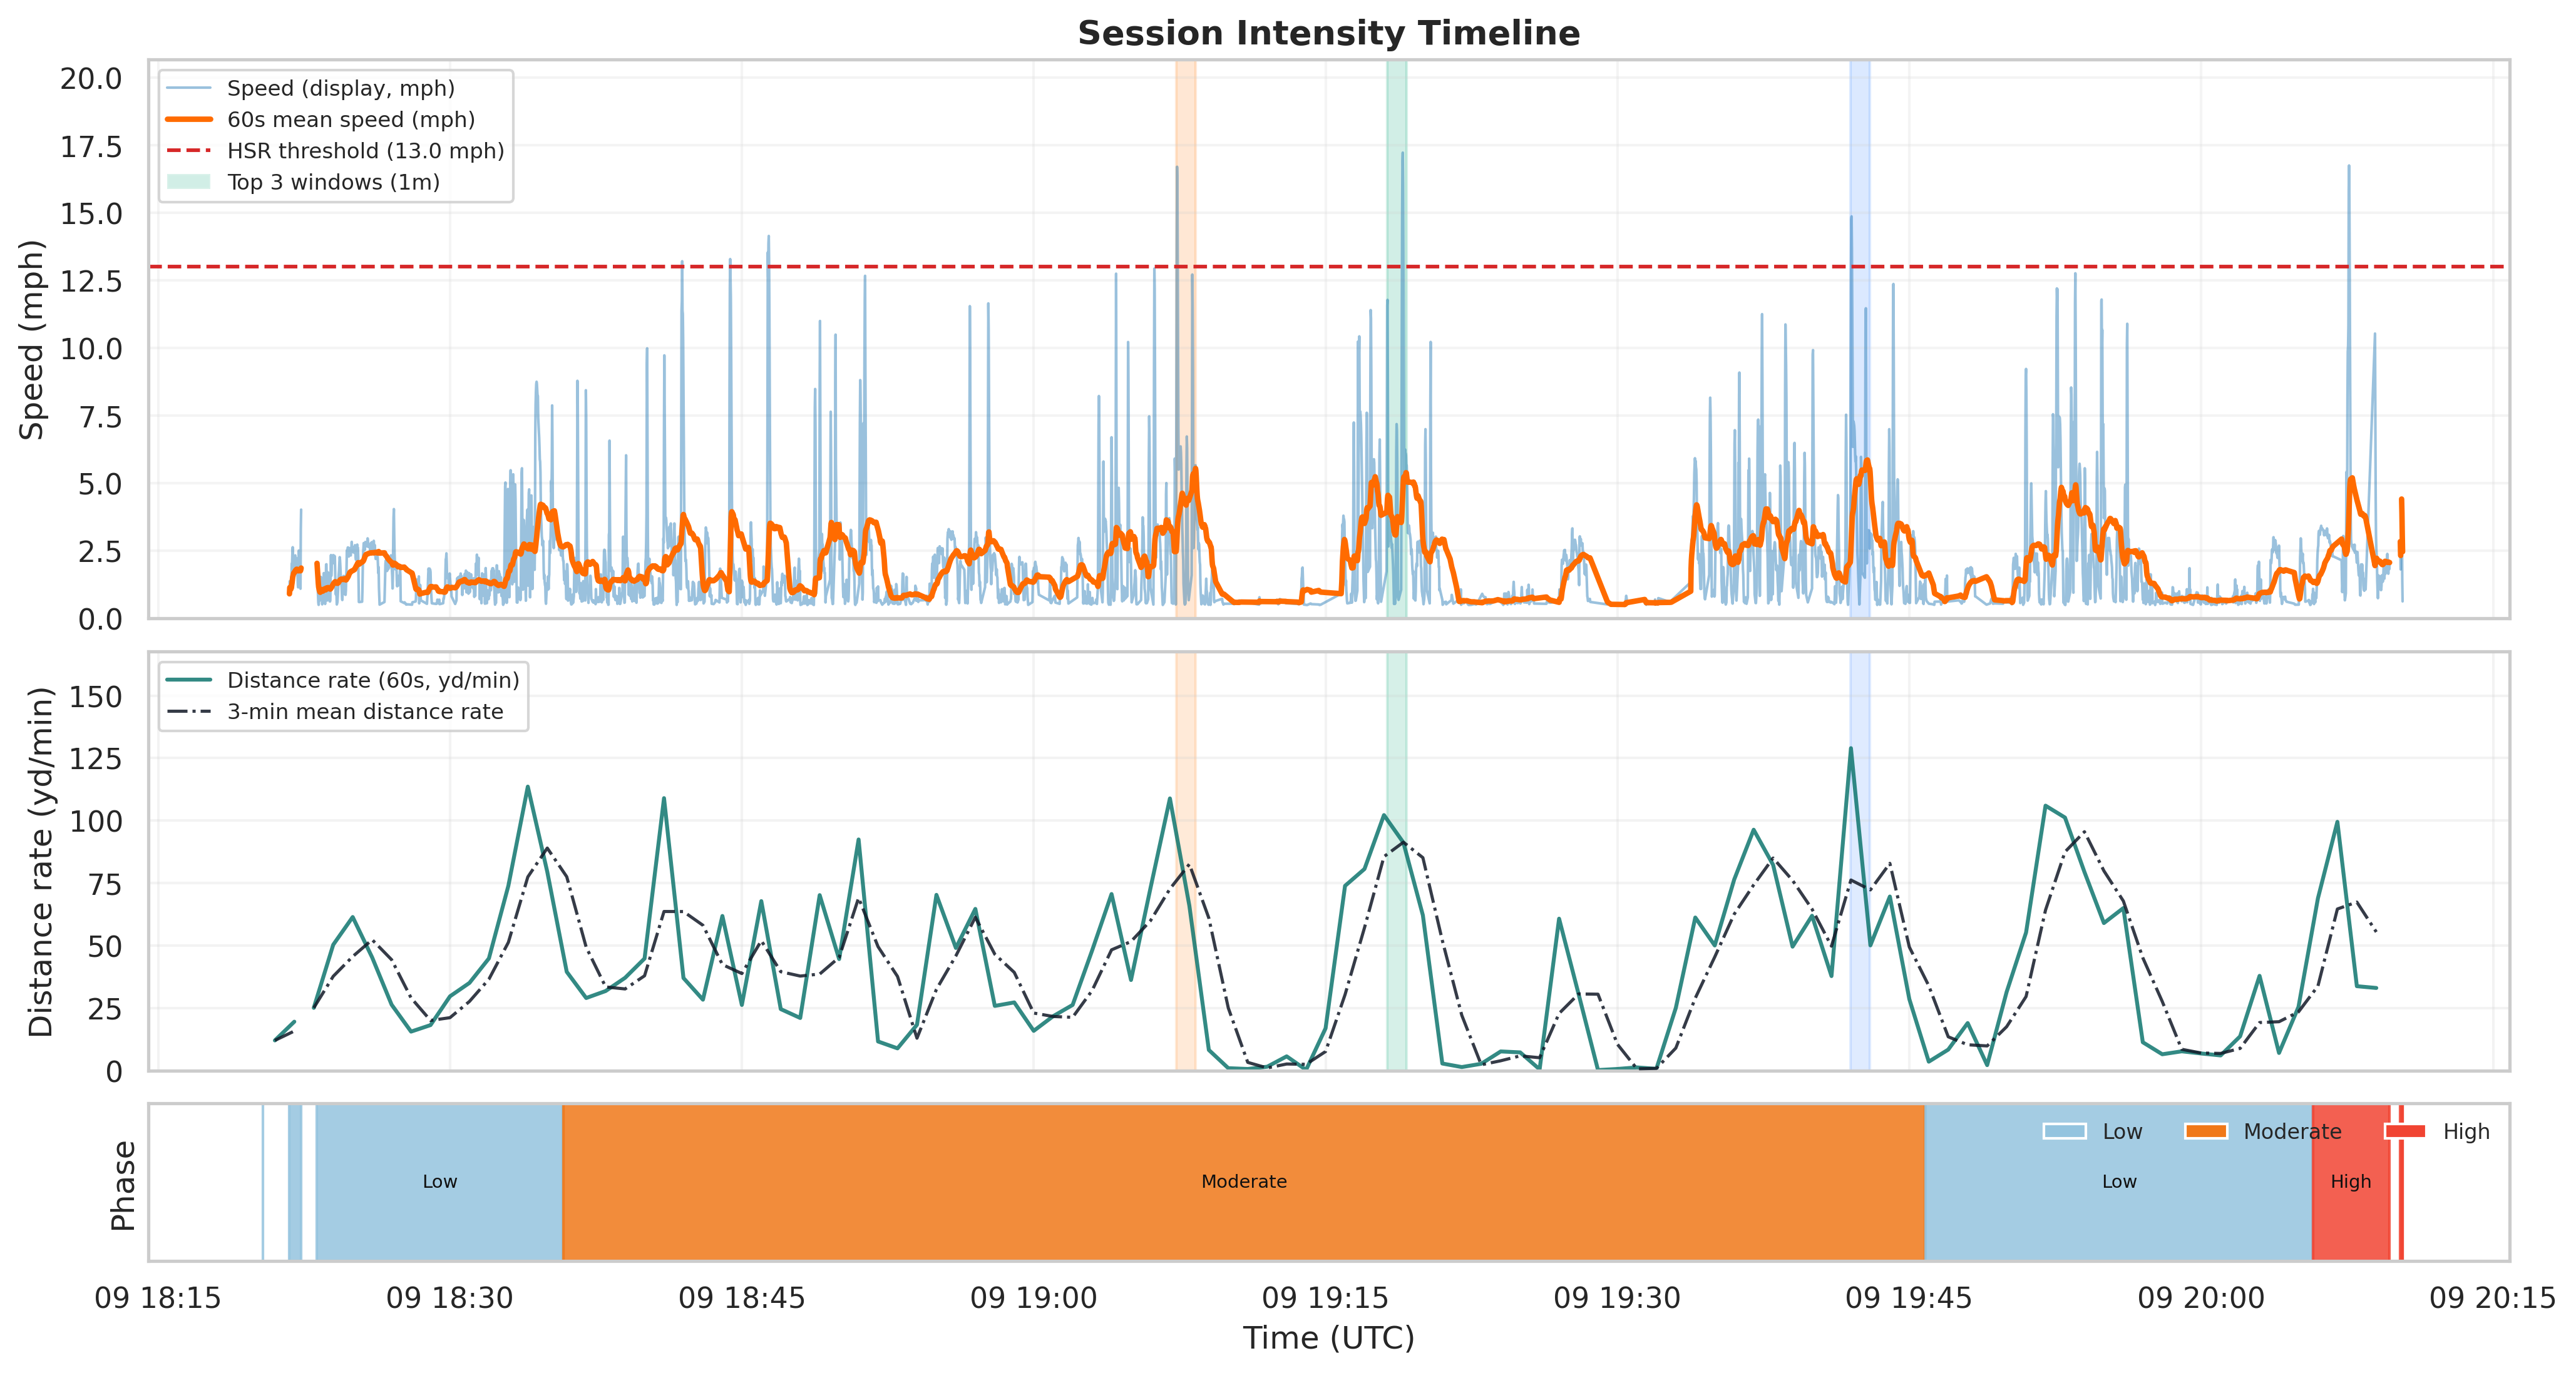

**Slide 4 | What: Peak demand windows and session maxima with event context**

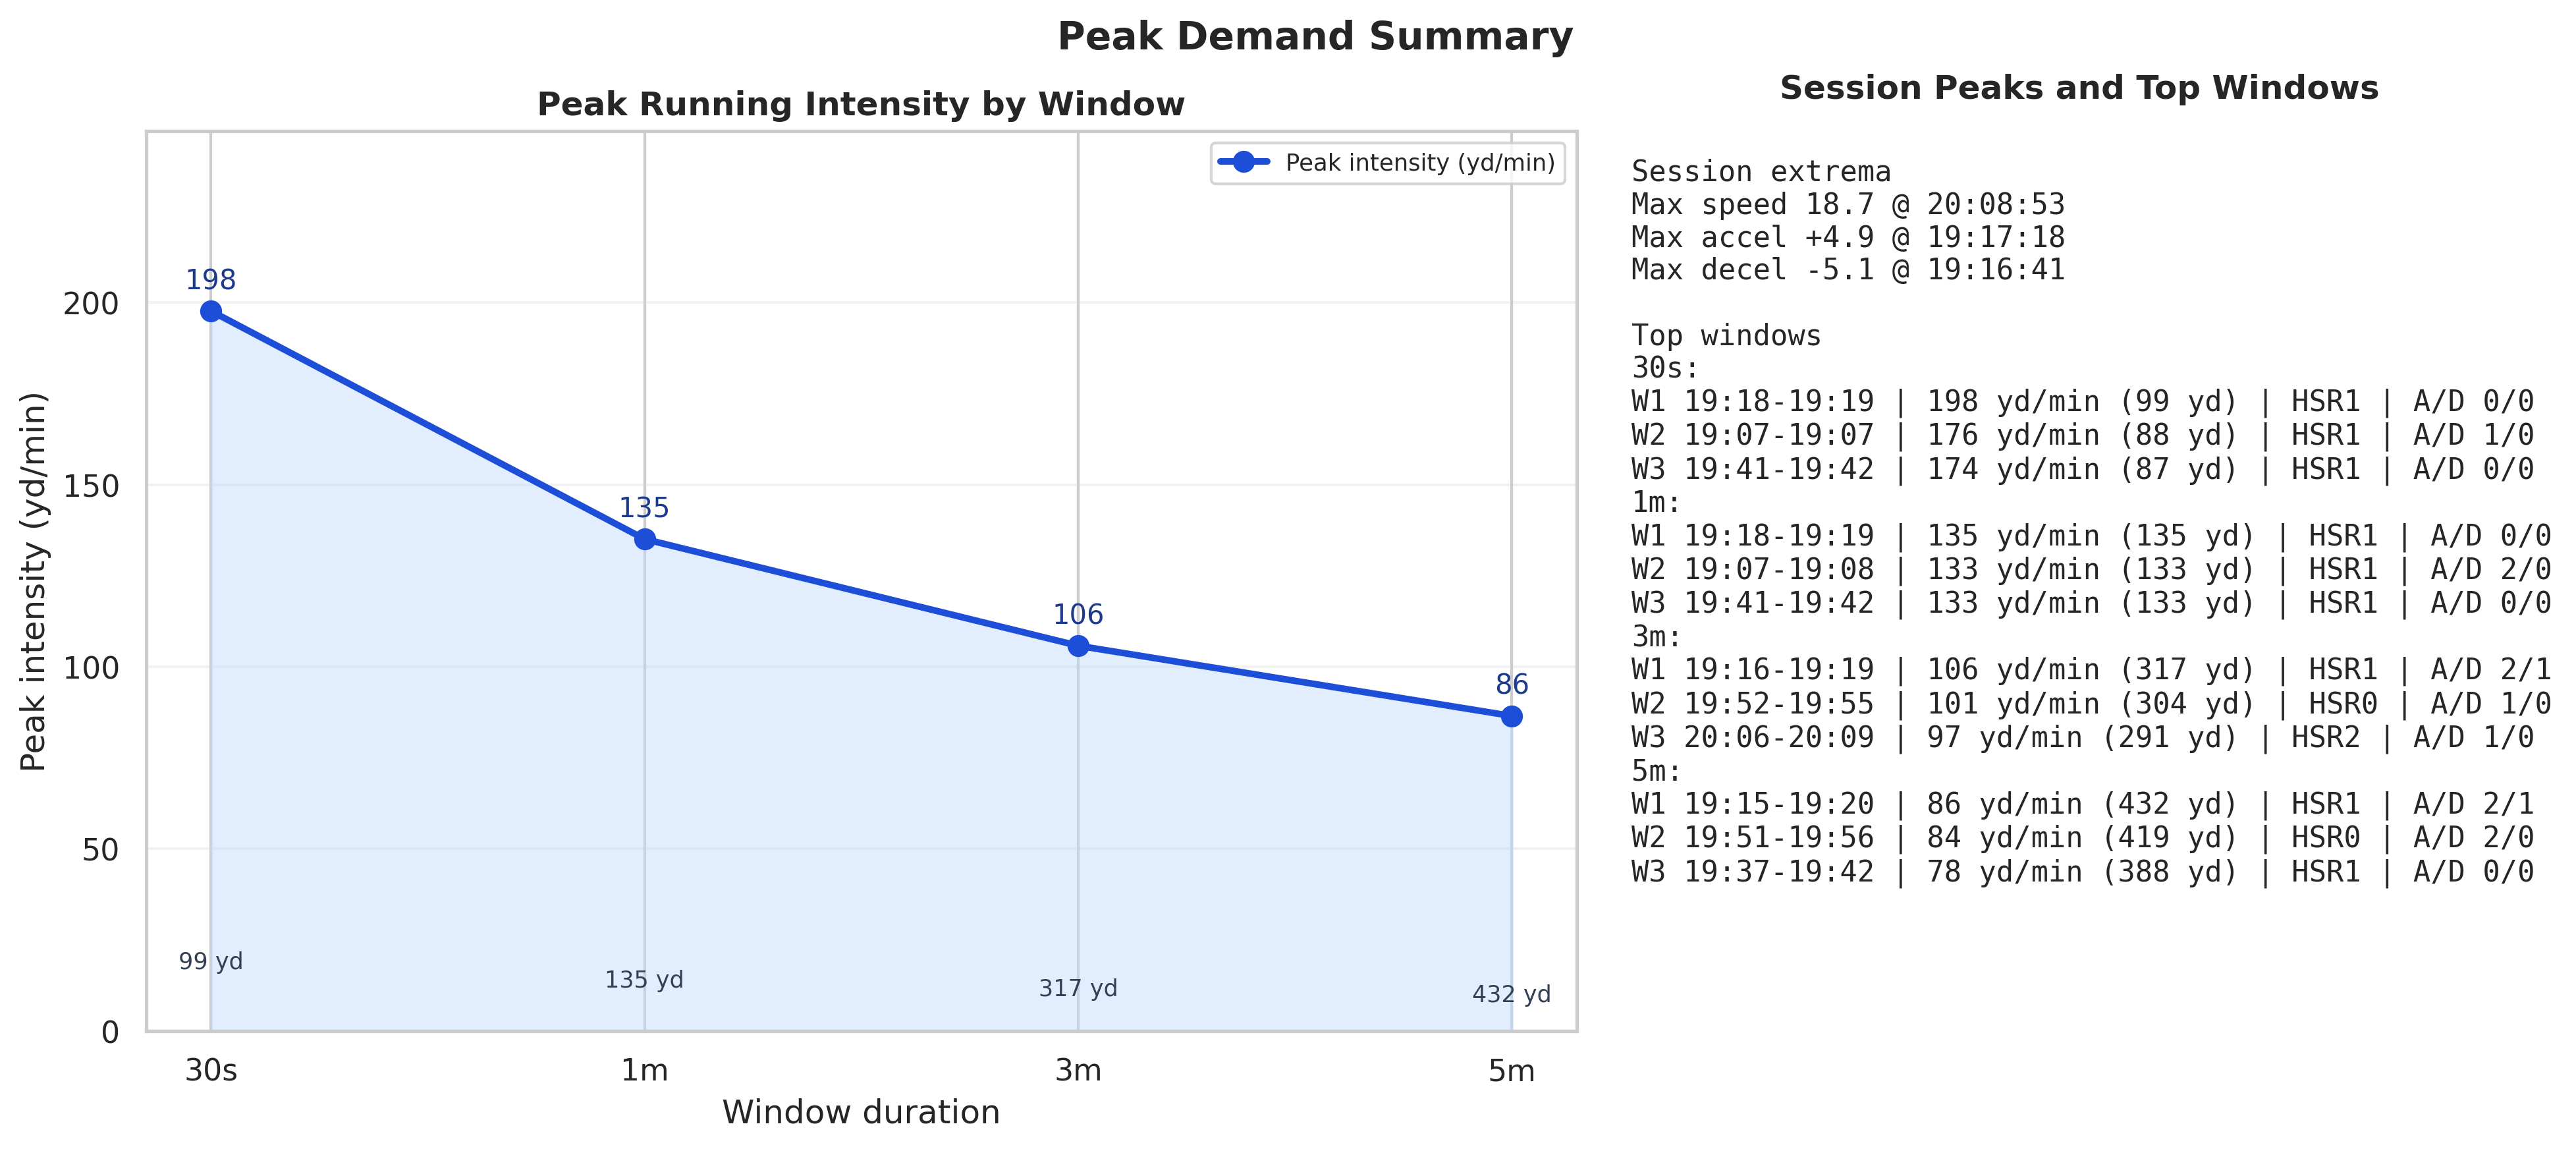

In [17]:
show_saved_png(
    FIG_DIR / '01_space.png',
    'Slide 2 | Where: Spatial usage and role signature (density + key demand windows)'
)
show_saved_png(
    FIG_DIR / '02_time.png',
    'Slide 3 | When: Intensity over time with phase strip, HSR events, and peak windows'
)
show_saved_png(
    FIG_DIR / '03_peaks.png',
    'Slide 4 | What: Peak demand windows and session maxima with event context'
)

## Coach/Player Summary Block

In [18]:
best_window = None
if not top_windows_by_duration.empty:
    best_candidates = top_windows_by_duration[top_windows_by_duration['window_s'] == 60]
    if best_candidates.empty:
        best_candidates = top_windows_by_duration
    best_window = best_candidates.copy()
    best_window['peak_intensity_yd_min'] = (
        pd.to_numeric(best_window['distance_yd'], errors='coerce')
        * (60.0 / pd.to_numeric(best_window['window_s'], errors='coerce').replace(0.0, pd.NA))
    ).fillna(0.0)
    best_window = best_window.sort_values('peak_intensity_yd_min', ascending=False).iloc[0]
coach_lines = [
    'Coach Lens',
    f"- Session phases: {len(coach_phase_summary)} merged blocks with clear intensity labels.",
    f"- QA status: {overall_status} ({qc_status}).",
    f"- Validation gates passed: {int((validation_gates['status'] == 'PASS').sum())}/{len(validation_gates)}.",
]
player_lines = [
    'Player Lens',
    f"- Peak speed: {float(session_summary['peak_speed_mph']):.2f} mph.",
    f"- HSR distance: {float(event_counts.get('hsr_distance_yd', 0.0)):.1f} yd.",
]
if best_window is not None:
    start = pd.Timestamp(best_window['window_start_utc']).strftime('%H:%M:%S')
    end = pd.Timestamp(best_window['window_end_utc']).strftime('%H:%M:%S')
    duration_label = f"{int(best_window['window_s'] // 60)}-min" if int(best_window['window_s']) % 60 == 0 else f"{int(best_window['window_s'])}s"
    coach_lines.append(
        f"- Key drill anchor: best {duration_label} intensity {float(best_window['peak_intensity_yd_min']):.1f} yd/min ({start}-{end} UTC)."
    )
    player_lines.append(
        f"- Best window load: {float(best_window['peak_intensity_yd_min']):.1f} yd/min ({float(best_window['distance_yd']):.1f} yd total)."
    )
summary_md = '### ' + '\n'.join(coach_lines) + '\n\n### ' + '\n'.join(player_lines)
display(Markdown(summary_md))

### Coach Lens
- Session phases: 8 merged blocks with clear intensity labels.
- QA status: WARN (QC WARN).
- Validation gates passed: 4/6.
- Key drill anchor: best 1-min intensity 135.1 yd/min (19:18:09-19:19:09 UTC).

### Player Lens
- Peak speed: 18.71 mph.
- HSR distance: 216.7 yd.
- Best window load: 135.1 yd/min (135.1 yd total).

## 1. Slide 1: Snapshot + Validation Gates

In [19]:
slide1_text = build_slide_1_snapshot_text(
    session_summary,
    hsr_threshold_mph=hsr_threshold_mph,
    event_summary=event_counts,
)
print(slide1_text)
write_slide_text(TEXT_DIR / 'slide_1_session_snapshot.txt', slide1_text)

speed_band_text = ', '.join(
    [
        (
            f"{band['name']} {band['lower_mph']:.0f}-{band['upper_mph']:.0f}"
            if band['upper_mph'] is not None
            else f"{band['name']} >= {band['lower_mph']:.0f}"
        )
        for band in speed_bands
    ]
)
definitions_text = (
    'Definitions and Assumptions\n'
    f"- Speed bands (mph): {speed_band_text}.\n"
    f"- HSR/Sprint thresholds: >= {hsr_threshold_mph:.1f} mph / >= {sprint_threshold_mph:.1f} mph.\n"
    f"- Accel/Decel thresholds: >= {accel_threshold_ms2:.1f} / <= {decel_threshold_ms2:.1f} m/s^2.\n"
    '- Acceleration signal policy: use signed `sa` channel for accel/decel events and extrema.\n'
    '- Event definition: contiguous threshold exposure >= 1.0 s.\n'
    f"- Unit conversions: speed yd/s -> mph x {speed_conversion_factor:.7f}; "
    f"accel yd/s^2 -> m/s^2 x {accel_conversion_factor:.4f}.\n"
    '- Distance policy: workload totals use speed-derived step distance (`s*dt`); vendor `dis` is QA-only.\n'
    '- Continuity policy: windows/events and trajectory lines reset at flagged gaps/improbable jumps.'
)
print(definitions_text)
write_slide_text(TEXT_DIR / 'slide_1_definitions_and_assumptions.txt', definitions_text)

qa_cols = [
    'overall_status',
    'sample_count', 'expected_cadence_s', 'pct_on_expected_cadence',
    'max_gap_s', 'gap_count', 'gap_pct', 'gap_threshold_s',
    'max_xy_step_yd', 'teleport_count', 'teleport_pct', 'teleport_speed_threshold_yd_s',
    'inactive_speed_threshold_mph', 'inactive_sample_count', 'inactive_sample_pct',
    'position_outlier_low_quantile', 'position_outlier_high_quantile',
    'position_outlier_count', 'position_outlier_pct',
    'speed_xy_alignment_samples', 'speed_xy_corr', 'speed_xy_error_p95_yd_s',
    'speed_xy_outlier_pct', 'speed_xy_outlier_threshold_yd_s',
    'step_distance_outlier_source',
    'step_distance_outlier_threshold_yd', 'step_distance_outlier_count',
    'step_distance_outlier_pct',
]
qa_cols = [col for col in qa_cols if col in qa_summary]
qa_table = pd.DataFrame([qa_summary])[qa_cols].rename(columns={
    'overall_status': 'Overall status',
    'sample_count': 'Sample count',
    'expected_cadence_s': 'Expected cadence (s)',
    'pct_on_expected_cadence': '% at expected cadence',
    'max_gap_s': 'Max gap (s)',
    'gap_count': 'Gap count',
    'gap_pct': 'Gap count (%)',
    'gap_threshold_s': 'Gap threshold (s)',
    'max_xy_step_yd': 'Max XY step (yd)',
    'teleport_count': 'Teleport count',
    'teleport_pct': 'Teleport count (%)',
    'teleport_speed_threshold_yd_s': 'Teleport threshold (yd/s)',
    'inactive_speed_threshold_mph': 'Inactive threshold (mph)',
    'inactive_sample_count': 'Inactive sample count',
    'inactive_sample_pct': 'Inactive sample (%)',
    'position_outlier_low_quantile': 'Position outlier q_low',
    'position_outlier_high_quantile': 'Position outlier q_high',
    'position_outlier_count': 'Position outlier count',
    'position_outlier_pct': 'Position outlier (%)',
    'speed_xy_alignment_samples': 'Speed/XY alignment samples',
    'speed_xy_corr': 'Speed vs XY corr (r)',
    'speed_xy_error_p95_yd_s': 'Speed vs XY error p95 (yd/s)',
    'speed_xy_outlier_pct': 'Speed vs XY outlier (%)',
    'speed_xy_outlier_threshold_yd_s': 'Speed vs XY outlier threshold (yd/s)',
    'step_distance_outlier_source': 'Outlier source',
    'step_distance_outlier_threshold_yd': 'Outlier threshold (yd)',
    'step_distance_outlier_count': 'Outlier count',
    'step_distance_outlier_pct': 'Outlier count (%)',
})
for col, digits in [
    ('Expected cadence (s)', 3),
    ('% at expected cadence', 2),
    ('Max gap (s)', 2),
    ('Gap threshold (s)', 2),
    ('Gap count (%)', 3),
    ('Max XY step (yd)', 2),
    ('Teleport count (%)', 3),
    ('Teleport threshold (yd/s)', 2),
    ('Inactive threshold (mph)', 2),
    ('Inactive sample (%)', 2),
    ('Position outlier q_low', 2),
    ('Position outlier q_high', 2),
    ('Position outlier (%)', 2),
    ('Speed vs XY corr (r)', 3),
    ('Speed vs XY error p95 (yd/s)', 2),
    ('Speed vs XY outlier (%)', 2),
    ('Speed vs XY outlier threshold (yd/s)', 2),
    ('Outlier threshold (yd)', 2),
    ('Outlier count (%)', 2),
]:
    if col in qa_table.columns:
        qa_table[col] = qa_table[col].round(digits)
display(qa_table)
qa_table.to_csv(TABLE_DIR / 'slide_1_data_quality_table.csv', index=False)

validation_table = validation_gates[['gate', 'status', 'value', 'threshold', 'direction', 'unit', 'notes']].copy()
validation_table.columns = ['Gate', 'Status', 'Value', 'Threshold', 'Direction', 'Unit', 'Notes']
validation_table['Value'] = pd.to_numeric(validation_table['Value'], errors='coerce').round(3)
display(validation_table)
validation_table.to_csv(TABLE_DIR / 'slide_1_validation_gates_table.csv', index=False)

pass_count = int((validation_gates['status'] == 'PASS').sum()) if not validation_gates.empty else 0
qa_text_lines = [
    'Data QA Summary',
    f"- QC: {qc_status}; Overall status: {overall_status}.",
    f"- {qa_table['% at expected cadence'].iloc[0]:.1f}% samples at 0.1s cadence.",
    f"- Max gap: {qa_table['Max gap (s)'].iloc[0]:.2f}s; gaps flagged above {qa_table['Gap threshold (s)'].iloc[0]:.2f}s.",
    (
        f"- Inactive samples (<= {qa_table['Inactive threshold (mph)'].iloc[0]:.1f} mph): {qa_table['Inactive sample (%)'].iloc[0]:.1f}%."
        if 'Inactive threshold (mph)' in qa_table.columns and 'Inactive sample (%)' in qa_table.columns
        else '- Inactive sample % unavailable.'
    ),
    (
        f"- Position outliers ({qa_table['Position outlier q_low'].iloc[0]:.2f}-{qa_table['Position outlier q_high'].iloc[0]:.2f} quantiles): {qa_table['Position outlier (%)'].iloc[0]:.2f}%."
        if 'Position outlier (%)' in qa_table.columns
        else '- Position outlier % unavailable.'
    ),
    (
        f"- Speed-vs-XY sanity: corr {qa_table['Speed vs XY corr (r)'].iloc[0]:.3f}, outliers {qa_table['Speed vs XY outlier (%)'].iloc[0]:.2f}%."
        if 'Speed vs XY corr (r)' in qa_table.columns and 'Speed vs XY outlier (%)' in qa_table.columns
        else '- Speed-vs-XY sanity metrics unavailable.'
    ),
    f"- Outlier threshold: {qa_table['Outlier threshold (yd)'].iloc[0]:.2f} yd; flagged {int(qa_table['Outlier count'].iloc[0])} samples ({qa_table['Outlier count (%)'].iloc[0]:.2f}%).",
    f"- Validation gates passed: {pass_count}/{len(validation_gates)}.",
]
if overall_status == 'WARN':
    qa_text_lines.append('- Interpretation policy: usable with caveats; windows/events/maps are continuity-masked.')
if overall_status == 'FAIL':
    qa_text_lines.append('- Interpretation policy: do not use this session for workload decision thresholds.')
qa_text_lines.extend([f"- {line}" for line in validation_takeaways[:3]])
qa_text = '\n'.join(qa_text_lines)
print(qa_text)
write_slide_text(TEXT_DIR / 'slide_1_data_quality_takeaways.txt', qa_text)

Session Snapshot
- Duration: 112.2 min
- Total distance: 4,841 yd
- Mean speed: 1.51 mph
- Peak speed: 18.71 mph
- Peak accel/decel: 4.93 / -5.12 m/s^2
- HSR threshold for this report: 13.0 mph
- Sampling gaps (>0.15 s): 6
- HSR/Sprint events (>=1s): 6 / 4
- Accel/Decel events: 20 / 4
Definitions and Assumptions
- Speed bands (mph): Walk 0-3, Cruise 3-9, Run 9-13, HSR 13-16, Sprint >= 16.
- HSR/Sprint thresholds: >= 13.0 mph / >= 16.0 mph.
- Accel/Decel thresholds: >= 3.0 / <= -3.0 m/s^2.
- Acceleration signal policy: use signed `sa` channel for accel/decel events and extrema.
- Event definition: contiguous threshold exposure >= 1.0 s.
- Unit conversions: speed yd/s -> mph x 2.0454545; accel yd/s^2 -> m/s^2 x 0.9144.
- Distance policy: workload totals use speed-derived step distance (`s*dt`); vendor `dis` is QA-only.
- Continuity policy: windows/events and trajectory lines reset at flagged gaps/improbable jumps.


,Overall status,Sample count,Expected cadence (s),% at expected cadence,Max gap (s),Gap count,Gap count (%),Gap threshold (s),Max XY step (yd),Teleport count,Teleport count (%),Teleport threshold (yd/s),Inactive threshold (mph),Inactive sample count,Inactive sample (%),Position outlier q_low,Position outlier q_high,Position outlier count,Position outlier (%),Speed/XY alignment samples,Speed vs XY corr (r),Speed vs XY error p95 (yd/s),Speed vs XY outlier (%),Speed vs XY outlier threshold (yd/s),Outlier source,Outlier threshold (yd),Outlier count,Outlier count (%)
0,WARN,65410,0.1,99.99,80.3,6,0.009,0.15,14.01,7,0.011,14.0,0.5,28213,43.13,0.01,0.99,2620,4.01,65410,0.904,0.1,0.07,2.0,step_distance_xy_yd,0.62,328,0.5


,Gate,Status,Value,Threshold,Direction,Unit,Notes
0,Cadence on target (%),PASS,99.991,95.0,>=,%,100.0% on-target cadence; gaps above 0.15s: 6 ...
1,Max time gap (s),WARN,80.300,0.5,<=,s,Max dt observed 80.30s (gate limit for pass 0....
2,Improbable position jump (%),PASS,0.011,0.5,<=,%,7 of 65410 samples imply XY speed > 14.0 yd/s.
3,Provided vs derived speed correlation,PASS,0.904,0.8,>=,r,Pearson correlation on 65410 aligned samples.
4,Provided vs derived speed outliers (%),PASS,0.070,3.0,<=,%,46 samples exceed |provided-derived| > 2.0 yd/s.
5,Vendor `dis` vs speed distance delta (%),WARN,74.662,20.0,<=,%,Absolute total-distance delta using vendor `di...


Data QA Summary
- QC: QC WARN; Overall status: WARN.
- 100.0% samples at 0.1s cadence.
- Max gap: 80.30s; gaps flagged above 0.15s.
- Inactive samples (<= 0.5 mph): 43.1%.
- Position outliers (0.01-0.99 quantiles): 4.01%.
- Speed-vs-XY sanity: corr 0.904, outliers 0.07%.
- Outlier threshold: 0.62 yd; flagged 328 samples (0.50%).
- Validation gates passed: 4/6.
- Interpretation policy: usable with caveats; windows/events/maps are continuity-masked.
- Validation gates: 4/6 PASS.
- Trust policy: distance and workload totals are computed from speed channel (`s`).
- Coordinate jumps are low; movement map can be used for role/space interpretation.


## 2. Slide 2: Speed Zones

In [20]:
slide2_table = coach_speed_band_table(speed_band_summary)
display(slide2_table)
slide2_table.to_csv(TABLE_DIR / 'slide_2_speed_zone_table.csv', index=False)

top_zone = slide2_table.sort_values('Distance (yd)', ascending=False).iloc[0]
hsr_label = classify_hsr_exposure(
    total_distance_yd=float(session_summary['distance_yd_from_speed']),
    hsr_distance_yd=float(event_counts.get('hsr_distance_yd', 0.0)),
)
slide2_text = (
    'Speed Zone Takeaways\n'
    f"- Largest distance accumulation: {top_zone['Zone']} ({top_zone['Distance (%)']:.1f}% of total distance).\n"
    f"- HSR exposure classification: {hsr_label}.\n"
    '- Action: adjust high-speed volume by phase, not by session average only.'
)
print(slide2_text)
write_slide_text(TEXT_DIR / 'slide_2_speed_zone_takeaways.txt', slide2_text)

,Zone,Distance (yd),Distance (%),Time (s),Time (%),Mean speed (mph)
0,Walk,2486.1,51.4,5879.5,87.3,0.89
1,Cruise,1696.8,35.1,741.4,11.0,4.68
2,Run,441.1,9.1,82.9,1.2,10.88
3,HSR,132.2,2.7,19.2,0.3,14.09
4,Sprint,84.4,1.7,10.0,0.1,17.27


Speed Zone Takeaways
- Largest distance accumulation: Walk (51.4% of total distance).
- HSR exposure classification: Low.
- Action: adjust high-speed volume by phase, not by session average only.


## 3. Slide 3: Peak Demands

In [21]:
slide3_distance = coach_peak_distance_table(distance_table)
slide3_extrema = coach_extrema_table(extrema)
slide3_events = pd.DataFrame([
    {
        'HSR events (>=1s)': int(event_counts.get('hsr_event_count', 0)),
        'Sprint events (>=1s)': int(event_counts.get('sprint_event_count', 0)),
        'Accel events': int(event_counts.get('accel_event_count', 0)),
        'Decel events': int(event_counts.get('decel_event_count', 0)),
        'HSR distance (yd)': float(event_counts.get('hsr_distance_yd', 0.0)),
        'Sprint distance (yd)': float(event_counts.get('sprint_distance_yd', 0.0)),
    }
])
slide3_events['HSR distance (yd)'] = slide3_events['HSR distance (yd)'].round(1)
slide3_events['Sprint distance (yd)'] = slide3_events['Sprint distance (yd)'].round(1)

slide3_top_windows = top_windows_by_duration[
    ['window_s', 'window_rank', 'window_start_utc', 'window_end_utc', 'distance_yd', 'dominant_phase', 'hsr_event_count', 'accel_event_count', 'decel_event_count']
].copy()
slide3_top_windows = slide3_top_windows.sort_values(['window_s', 'window_rank']).reset_index(drop=True)
if not slide3_top_windows.empty:
    slide3_top_windows['peak_intensity_yd_min'] = (
        pd.to_numeric(slide3_top_windows['distance_yd'], errors='coerce')
        * (60.0 / pd.to_numeric(slide3_top_windows['window_s'], errors='coerce').replace(0.0, pd.NA))
    ).fillna(0.0)
slide3_top_windows['Window duration'] = slide3_top_windows['window_s'].map(
    lambda s: f"{int(s // 60)}m" if int(s) % 60 == 0 else f"{int(s)}s"
)
slide3_top_windows = slide3_top_windows.rename(columns={
    'window_rank': 'Window',
    'window_start_utc': 'Start (UTC)',
    'window_end_utc': 'End (UTC)',
    'peak_intensity_yd_min': 'Peak intensity (yd/min)',
    'distance_yd': 'Distance in window (yd)',
    'dominant_phase': 'Dominant phase',
    'hsr_event_count': 'HSR events',
    'accel_event_count': 'Accel events',
    'decel_event_count': 'Decel events',
})
slide3_top_windows = slide3_top_windows[
    ['Window duration', 'Window', 'Start (UTC)', 'End (UTC)', 'Peak intensity (yd/min)', 'Distance in window (yd)', 'Dominant phase', 'HSR events', 'Accel events', 'Decel events']
]
slide3_top_windows['Start (UTC)'] = pd.to_datetime(
    slide3_top_windows['Start (UTC)'],
    utc=True,
    format='mixed',
).dt.strftime('%H:%M:%S')
slide3_top_windows['End (UTC)'] = pd.to_datetime(
    slide3_top_windows['End (UTC)'],
    utc=True,
    format='mixed',
).dt.strftime('%H:%M:%S')
slide3_top_windows['Peak intensity (yd/min)'] = slide3_top_windows['Peak intensity (yd/min)'].round(1)
slide3_top_windows['Distance in window (yd)'] = slide3_top_windows['Distance in window (yd)'].round(1)

display(slide3_distance)
display(slide3_extrema)
display(slide3_events)
display(slide3_top_windows)

slide3_distance.to_csv(TABLE_DIR / 'slide_3_peak_distance_table.csv', index=False)
slide3_extrema.to_csv(TABLE_DIR / 'slide_3_extrema_table.csv', index=False)
slide3_events.to_csv(TABLE_DIR / 'slide_3_event_counts_table.csv', index=False)
slide3_top_windows.to_csv(TABLE_DIR / 'slide_3_top_windows_table.csv', index=False)

if slide3_top_windows.empty:
    slide3_text = 'Peak Demand Takeaways\n- Not enough samples to derive stable top-demand windows.'
else:
    best_candidates = top_windows_by_duration[top_windows_by_duration['window_s'] == 60]
    if best_candidates.empty:
        best_candidates = top_windows_by_duration
    best = best_candidates.copy()
    best['peak_intensity_yd_min'] = (
        pd.to_numeric(best['distance_yd'], errors='coerce')
        * (60.0 / pd.to_numeric(best['window_s'], errors='coerce').replace(0.0, pd.NA))
    ).fillna(0.0)
    best = best.sort_values('peak_intensity_yd_min', ascending=False).iloc[0]
    best_start = pd.Timestamp(best['window_start_utc']).strftime('%H:%M:%S')
    best_end = pd.Timestamp(best['window_end_utc']).strftime('%H:%M:%S')
    duration_label = f"{int(best['window_s'] // 60)}-min" if int(best['window_s']) % 60 == 0 else f"{int(best['window_s'])}s"
    slide3_text = (
        'Peak Demand Takeaways\n'
        f"- Best {duration_label} intensity: {float(best['peak_intensity_yd_min']):.1f} yd/min ({float(best['distance_yd']):.1f} yd) from {best_start} to {best_end} UTC.\n"
        f"- Context: HSR/Sprint {int(best['hsr_event_count'])}/{int(best['sprint_event_count'])}; Acc/Dec {int(best['accel_event_count'])}/{int(best['decel_event_count'])}.\n"
        f"- Dominant phase: {best['dominant_phase'] or 'N/A'}.\n"
        '- Action: use this window to set drill-level peak-demand targets.'
    )
print(slide3_text)
write_slide_text(TEXT_DIR / 'slide_3_peak_takeaways.txt', slide3_text)

,Window,Peak intensity (yd/min),Best distance (yd),Start (UTC),End (UTC)
0,30s,197.7,98.8,19:18:54,19:19:24
1,1m,135.1,135.1,19:18:09,19:19:09
2,3m,105.8,317.3,19:16:25,19:19:25
3,5m,86.5,432.4,19:15:50,19:20:50


,Metric,Value,Time (UTC)
0,Max speed (mph),18.71,20:08:53
1,Max accel (m/s^2),4.93,19:17:18
2,Max decel (m/s^2),-5.12,19:16:41


,HSR events (>=1s),Sprint events (>=1s),Accel events,Decel events,HSR distance (yd),Sprint distance (yd)
0,6,4,20,4,216.7,84.4


,Window duration,Window,Start (UTC),End (UTC),Peak intensity (yd/min),Distance in window (yd),Dominant phase,HSR events,Accel events,Decel events
0,30s,1,19:18:54,19:19:24,197.7,98.8,Phase 03: Conditioning Push (Moderate),1,0,0
1,30s,2,19:07:13,19:07:43,175.6,87.8,Phase 03: Conditioning Push (Moderate),1,1,0
2,30s,3,19:41:57,19:42:27,174.4,87.2,Phase 03: Conditioning Push (Moderate),1,0,0
3,1m,1,19:18:09,19:19:09,135.1,135.1,Phase 03: Conditioning Push (Moderate),1,0,0
4,1m,2,19:07:19,19:08:19,133.1,133.1,Phase 03: Conditioning Push (Moderate),1,2,0
5,1m,3,19:41:58,19:42:58,133.1,133.1,Phase 03: Conditioning Push (Moderate),1,0,0
6,3m,1,19:16:25,19:19:25,105.8,317.3,Phase 03: Conditioning Push (Moderate),1,2,1
7,3m,2,19:52:21,19:55:21,101.4,304.1,Phase 05: Technical / Install (Low),0,1,0
8,3m,3,20:06:00,20:09:00,97.1,291.2,Phase 07: Conditioning Push (High),2,1,0
9,5m,1,19:15:50,19:20:50,86.5,432.4,Phase 03: Conditioning Push (Moderate),1,2,1


Peak Demand Takeaways
- Best 1-min intensity: 135.1 yd/min (135.1 yd) from 19:18:09 to 19:19:09 UTC.
- Context: HSR/Sprint 1/1; Acc/Dec 0/0.
- Dominant phase: Phase 03: Conditioning Push (Moderate).
- Action: use this window to set drill-level peak-demand targets.


## 4. Slide 4: Session Phases

In [22]:
slide4_table = coach_segment_table(coach_phase_summary, top_n=8)
display(slide4_table)
slide4_table.to_csv(TABLE_DIR / 'slide_4_segment_table.csv', index=False)

top_phase = coach_phase_summary.sort_values('distance_yd', ascending=False).iloc[0]
high_phase_count = int((coach_phase_summary['intensity_level'] == 'High').sum())
slide4_text = (
    'Session Phase Takeaways\n'
    f"- Session merged into {len(coach_phase_summary)} coach-readable phases.\n"
    f"- Highest volume phase: {top_phase['coach_phase_label']} ({top_phase['distance_yd']:.1f} yd across {top_phase['duration_s'] / 60.0:.1f} min).\n"
    f"- High-intensity phases identified: {high_phase_count}.\n"
    '- Action: use phase boundaries as planning blocks for next session design.'
)
print(slide4_text)
write_slide_text(TEXT_DIR / 'slide_4_segment_takeaways.txt', slide4_text)

,Phase,Phase type,Intensity,Duration (min),Distance (yd),HSR distance (yd),Accel events,Decel events,Mean speed (mph),Peak speed (mph),Peak 60s distance (yd)
0,Phase 03: Conditioning Push (Moderate),Conditioning Push,Moderate,70.04,3089.6,130.5,16,4,1.50,17.33,135.1
1,Phase 05: Technical / Install (Low),Technical / Install,Low,7.37,518.2,7.8,2,0,2.40,13.51,127.7
2,Phase 01: Warm-up (Low),Warm-up,Low,12.81,389.4,0.0,0,0,1.26,4.22,64.2
3,Phase 07: Conditioning Push (High),Conditioning Push,High,4.75,365.9,78.3,1,0,2.64,18.71,114.2
4,Phase 02: Technical / Install (Low),Technical / Install,Low,3.00,277.6,0.0,1,0,3.16,8.78,123.5
5,Phase 06: Technical / Install (Low),Technical / Install,Low,8.06,143.0,0.0,0,0,0.60,3.08,43.7
6,Phase 04: Technical / Install (Low),Technical / Install,Low,4.47,56.6,0.0,0,0,0.43,2.01,29.9
7,Phase 08: Cool-down / Walkthrough (Low),Cool-down / Walkthrough,Low,1.71,0.5,0.0,0,0,0.02,0.16,0.5


Session Phase Takeaways
- Session merged into 8 coach-readable phases.
- Highest volume phase: Phase 03: Conditioning Push (Moderate) (3089.6 yd across 70.0 min).
- High-intensity phases identified: 1.
- Action: use phase boundaries as planning blocks for next session design.


## 5. Slide 5: Early vs Late

In [23]:
slide5_table = coach_early_late_table(early_late_summary)
display(slide5_table)
slide5_table.to_csv(TABLE_DIR / 'slide_5_early_late_table.csv', index=False)

if len(slide5_table) == 2:
    late = slide5_table.loc[slide5_table['Period'] == 'Late Half'].iloc[0]
    slide5_text = (
        'Early vs Late Takeaways\n'
        f"- Late-half distance vs early-half: {late['Distance vs early (%)']:+.1f}%.\n"
        f"- Late-half HSR/Sprint events: {int(late['HSR events'])}/{int(late['Sprint events'])}.\n"
        f"- Late-half accel/decel events: {int(late['Accel events'])}/{int(late['Decel events'])}.\n"
        '- Action: adjust second-half progression if high-speed or braking load drifts from intent.'
    )
else:
    slide5_text = 'Early vs Late Takeaways\n- Insufficient data for split-half comparison.'
print(slide5_text)
write_slide_text(TEXT_DIR / 'slide_5_early_late_takeaways.txt', slide5_text)

,Period,Duration (min),Distance (yd),Distance vs early (%),Mean speed (mph),Peak speed (mph),HSR distance (yd),Sprint distance (yd),HSR events,Sprint events,Accel events,Decel events
0,Early Half,56.11,2335.0,0.0,1.48,17.12,72.2,12.3,2,1,14,3
1,Late Half,56.11,2505.8,7.3,1.55,18.71,144.5,72.2,4,3,6,1


Early vs Late Takeaways
- Late-half distance vs early-half: +7.3%.
- Late-half HSR/Sprint events: 4/3.
- Late-half accel/decel events: 6/1.
- Action: adjust second-half progression if high-speed or braking load drifts from intent.


## 6. Figure Aliases for Slide Deck

In [24]:
figure_aliases = {
    '01_space.png': 'coach_slide_movement_map.png',
    '02_time.png': 'coach_slide_intensity_timeline.png',
    '03_peaks.png': 'coach_slide_peak_demand_summary.png',
}
for src, dst in figure_aliases.items():
    source = FIG_DIR / src
    if not source.exists():
        raise FileNotFoundError(f'Missing {source}. Run Notebook 01 first.')
    shutil.copyfile(source, FIG_DIR / dst)

('Saved aliases', FIG_DIR / 'coach_slide_movement_map.png', FIG_DIR / 'coach_slide_intensity_timeline.png', FIG_DIR / 'coach_slide_peak_demand_summary.png')

('Saved aliases',
 WindowsPath('C:/docker_projects/browns_performance_science_fellowship/outputs/figures/coach_slide_movement_map.png'),
 WindowsPath('C:/docker_projects/browns_performance_science_fellowship/outputs/figures/coach_slide_intensity_timeline.png'),
 WindowsPath('C:/docker_projects/browns_performance_science_fellowship/outputs/figures/coach_slide_peak_demand_summary.png'))